In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

Использование графического процессора для меньшего времени обучения 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")         

# **Подготовка данных**


---



Преобразование данных в тензоры, нормализация точек в значения в промежутке [-1,1]


In [3]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10('./', download=True, train=True, transform=trans)
test_dataset = datasets.CIFAR10('./', download=True, train=False, transform=trans)


100%|██████████| 170498071/170498071 [00:03<00:00, 45957442.70it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
print(f"Длина тренировочного датасета: {len(train_dataset)}")
print(f"Длина тестового датасета: {len(test_dataset)}")

Длина тренировочного датасета: 50000
Длина тестового датасета: 10000


In [ ]:
print(f"Размерность тренировочного датасета: {train_dataset.data.shape}")
print(f"Размерность тестового датасета: {test_dataset.data.shape}")

Размерность тренировочного датасета: (50000, 32, 32, 3)
Размерность тестового датасета: (10000, 32, 32, 3)


In [4]:
classes = train_dataset.classes
print(f"Классов:{len(train_dataset.classes)}", classes)

Классов:10 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


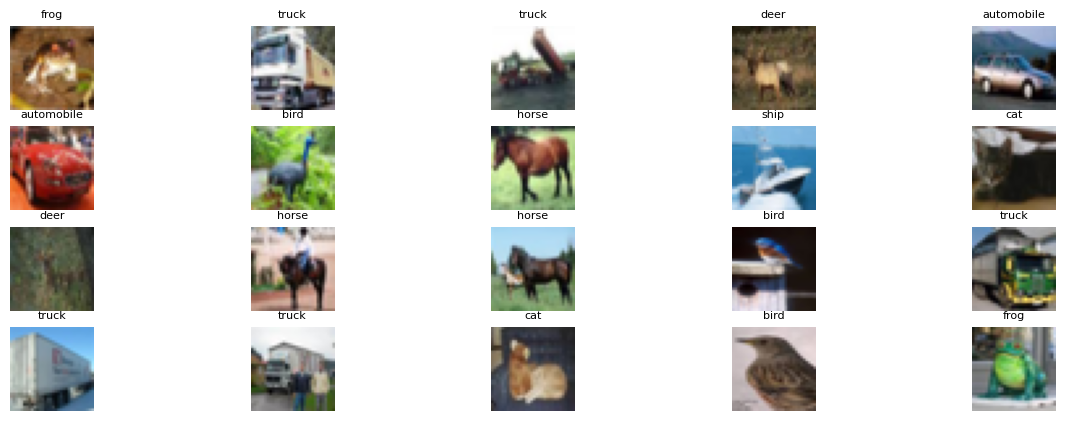

In [ ]:
pos = 0
fig = plt.figure(figsize=(15,5))
for img in range(20):
  fig.add_subplot(4,5, pos+1)
  plt.imshow(train_dataset.data[img])
  plt.title(classes[train_dataset.targets[img]], fontsize=8)
  plt.axis(False)
  pos += 1


Обращаясь к атрибуту data объекта train_dataset, получаем изначальные данные датасета, где элементы - числа от 0 до 255, уровни яркости пикселей 3х каналов RGB

In [ ]:
print(f"min={train_dataset.data.min()}, max={train_dataset.data.max()}") 
print(train_dataset.data[0])

min=0, max=255
[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


Тут уже train_dataset имеет нормализованные данные от -1 до 1, каждый элемент представляет собой кортеж с изображением - тензором и классом изображения

In [ ]:
print(f"min={train_dataset[0][0].min()}, max={train_dataset[0][0].max()}") 
print(train_dataset[0])


min=-1.0, max=1.0
(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000

Каждое изображение представляет собой 3 матрицы размером 32x32 пикселя для каждого из 3х каналов RGB

In [ ]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
(train_dataset[0][0][2].shape)

torch.Size([32, 32])

Все классы равномерно распределены как в обучающем наборе, так и в тестовом

In [ ]:
df_train = pd.DataFrame(train_dataset.targets)
df_test = pd.DataFrame(test_dataset.targets)
print(df_train.value_counts(), df_test.value_counts())

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
dtype: int64 0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
dtype: int64


# **Архитектура нейронной сети**

---



In [5]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 1-колво входных каналов=3, 2-колво выходных каналов
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1))
      
        self.drop_out = nn.Dropout()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(29*29*128, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.reshape(out.size(0), -1)

        out = self.drop_out(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()

        # self.fc1 = nn.Sequential(
        #     nn.Linear(32*32*3, 1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, 512),
        #     nn.ReLU(),
        #     nn.Linear(512, 10))

        self.fc1 = nn.Linear(32*32*3, 3000)
        self.drop_out1 = nn.Dropout()
        self.fc2 = nn.Linear(3000, 1024)
        self.drop_out2 = nn.Dropout()
        self.fc3 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()


    def forward(self, x):

        out = self.flatten(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.drop_out1(out)
        out = self.fc2(out)
        out = self.drop_out2(out)
        out = self.relu(out)
        out = self.fc3(out)
        # # out = self.drop_out(out)
        # out = self.fc3(out)
        return out

In [6]:
num_classes = 10
batch_size = 100
learning_rate = 0.0001

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
num_epochsCNN = 10

modelCNN = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=learning_rate)

In [16]:
num_epochsANN = 30

modelANN = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelANN.parameters(), lr=learning_rate)

In [17]:
train_on_gpu = torch.cuda.is_available()
# Перемещение данных на графический процессор (GPU), если он доступен
if train_on_gpu:
    modelCNN.cuda()
    modelANN.cuda()
    print("CUDA доступна! Модели перемещены на GPU")

CUDA доступна! Модели перемещены на GPU


Обучение сверточной нейронной сети CNN

In [ ]:
%%time            
loss_CNN = []
acc_CNN = []    

for epoch in range(num_epochsCNN):
    for i, (images, labels) in enumerate(train_loader):
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Прямое распространение
        outputs = modelCNN(images)
        loss = criterion(outputs, labels)
        loss_CNN.append(loss.item())

        # Обратное распространение
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Вычисление точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_CNN.append(correct / total)

        if (i + 1) % 500 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochsCNN, loss.item(), (correct / total) * 100))


Epoch [1/10], Loss: 1.2081, Accuracy: 55.00%
Epoch [2/10], Loss: 0.9752, Accuracy: 64.00%
Epoch [3/10], Loss: 0.9332, Accuracy: 67.00%
Epoch [4/10], Loss: 0.8473, Accuracy: 73.00%
Epoch [5/10], Loss: 0.6558, Accuracy: 80.00%
Epoch [6/10], Loss: 0.6864, Accuracy: 83.00%
Epoch [7/10], Loss: 0.6613, Accuracy: 76.00%
Epoch [8/10], Loss: 0.5526, Accuracy: 85.00%
Epoch [9/10], Loss: 0.6354, Accuracy: 81.00%
Epoch [10/10], Loss: 0.5073, Accuracy: 81.00%
CPU times: user 6min 32s, sys: 1.45 s, total: 6min 34s
Wall time: 7min 4s


Обучение ANN(полносвязной нейронной сети)

In [18]:
%%time                 
loss_ANN = []
acc_ANN = []             

for epoch in range(num_epochsANN):
    for i, (images, labels) in enumerate(train_loader):
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Прямое распространение
        outputs = modelANN(images)
        loss = criterion(outputs, labels)
        loss_ANN.append(loss.item())

        # Обратное распространение
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Вычисление точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_ANN.append(correct / total)

        if (i + 1) % 500 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochsANN, loss.item(), (correct / total) * 100))


Epoch [1/30], Loss: 1.5984, Accuracy: 39.00%
Epoch [2/30], Loss: 1.4422, Accuracy: 51.00%
Epoch [3/30], Loss: 1.6656, Accuracy: 46.00%
Epoch [4/30], Loss: 1.4331, Accuracy: 59.00%
Epoch [5/30], Loss: 1.4889, Accuracy: 47.00%
Epoch [6/30], Loss: 1.1157, Accuracy: 64.00%
Epoch [7/30], Loss: 1.2595, Accuracy: 53.00%
Epoch [8/30], Loss: 1.2323, Accuracy: 56.00%
Epoch [9/30], Loss: 1.3332, Accuracy: 49.00%
Epoch [10/30], Loss: 1.0631, Accuracy: 62.00%
Epoch [11/30], Loss: 1.2173, Accuracy: 66.00%
Epoch [12/30], Loss: 1.3023, Accuracy: 58.00%
Epoch [13/30], Loss: 1.0839, Accuracy: 60.00%
Epoch [14/30], Loss: 1.0710, Accuracy: 62.00%
Epoch [15/30], Loss: 1.0516, Accuracy: 65.00%
Epoch [16/30], Loss: 1.0829, Accuracy: 56.00%
Epoch [17/30], Loss: 1.1182, Accuracy: 63.00%
Epoch [18/30], Loss: 0.8899, Accuracy: 67.00%
Epoch [19/30], Loss: 0.9313, Accuracy: 65.00%
Epoch [20/30], Loss: 0.9378, Accuracy: 62.00%
Epoch [21/30], Loss: 0.9851, Accuracy: 64.00%
Epoch [22/30], Loss: 0.9184, Accuracy: 66.0

# **Оценка промежуточных результатов**

---




График изменения accuracy(точности) в зависимости от партии (в CNN -сверточной нейросети) 

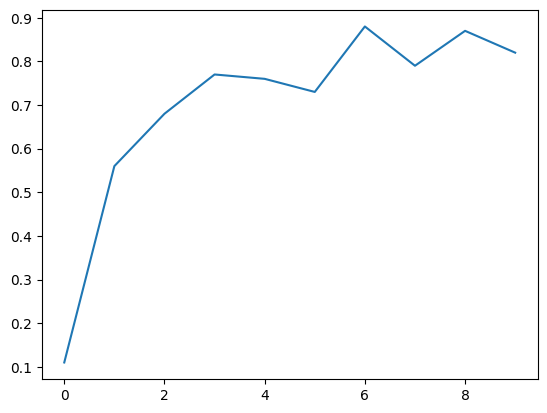

In [ ]:
plt.plot(torch.arange(len(acc_CNN[::500])), acc_CNN[::500]) 

График изменения функции ошибки в зависимости от партии (в CNN -сверточной нейросети)

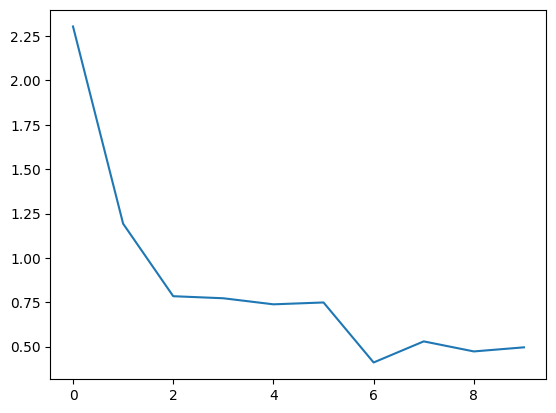

In [ ]:
plt.plot(torch.arange(len(loss_CNN[::500])), loss_CNN[::500]) 

График изменения accuracy(точности) в зависимости от партии (в ANN - полносвязной нейросети) 

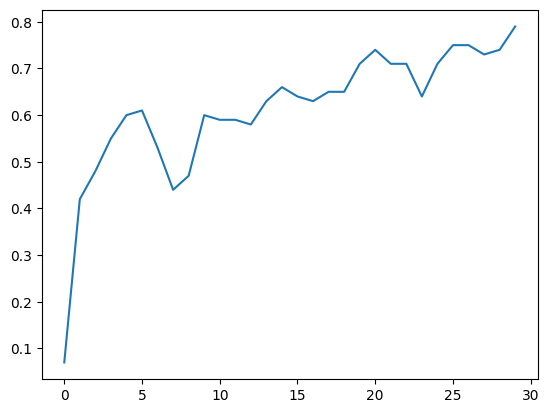

In [19]:
plt.plot(torch.arange(len(acc_ANN[::500])), acc_ANN[::500]) 

График изменения функции ошибки в зависимости от партии (в ANN - полносвязной нейросети) 

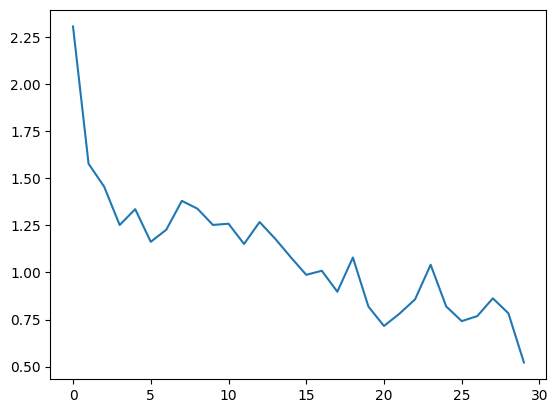

In [20]:
plt.plot(torch.arange(len(loss_ANN[::500])), loss_ANN[::500]) 

# **Оценка на тестовом датасете**

---



Сверточная нейронная сеть

In [ ]:
modelCNN.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = modelCNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность модели на тестовом наборе из 10000 изображений: {} %'.format((correct / total) * 100))


Точность модели на тестовом наборе из 10000 изображений: 72.58 %


Результат хороший, еще и при том, что метод eval() переключает модель в режим оценки, отключая слои регуляризации(дропаут) и нормализации партий для более честного анализа эффективности


In [ ]:
# Получаем данные с тестовой выборки
y_pred = []
y_true = []

for inputs, labels in test_loader:
    inputs, labels = inputs.cuda(), labels.cuda()
    output = modelCNN(inputs) # Обучение модели
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Сохранение предсказания
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Сохранение правльного ответа
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.81      0.75      1000
           1       0.83      0.82      0.82      1000
           2       0.58      0.67      0.62      1000
           3       0.57      0.55      0.56      1000
           4       0.69      0.66      0.67      1000
           5       0.70      0.64      0.66      1000
           6       0.84      0.74      0.79      1000
           7       0.77      0.80      0.78      1000
           8       0.85      0.78      0.81      1000
           9       0.79      0.81      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



В первом столбце 10 классов, правее - метрики precision(точнось), recall(полнота), f1-score.  В зависимости о класса, результаты довольно разрозненны, но в целом хороши. В среднем, можно сказать, что эффективность модели около 70%

Нейронная сеть прямого распространения

In [23]:
modelANN.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = modelANN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность модели на тестовом наборе из 10000 изображений: {} %'.format((correct / total) * 100))


Точность модели на тестовом наборе из 10000 изображений: 58.56 %


In [22]:
# Получаем данные с тестовой выборки
y_pred = []
y_true = []

for inputs, labels in test_loader:
    inputs, labels = inputs.cuda(), labels.cuda()
    output = modelANN(inputs)  # Обучение модели
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Сохранение предсказания
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Сохранение правльного ответа
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67      1000
           1       0.69      0.69      0.69      1000
           2       0.48      0.48      0.48      1000
           3       0.45      0.33      0.38      1000
           4       0.50      0.53      0.51      1000
           5       0.46      0.55      0.50      1000
           6       0.68      0.57      0.62      1000
           7       0.60      0.68      0.64      1000
           8       0.72      0.70      0.71      1000
           9       0.63      0.64      0.64      1000

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.58     10000
weighted avg       0.59      0.59      0.58     10000



Здесь же результат немного хуже тренировочного